# Custom CNN for HER2 IHC Image Classification
## Info
### Version: V2.1.0
#### Changes:
Updated Dataset!

In [1]:
# Version information
version_info = """
Project Version: 2.1.0
Release Date: 2025-01-15
Author: Saky
"""

In [2]:
# Write to version.txt
with open("/kaggle/working/version.txt", "w") as f:
    f.write(version_info)

# Check the content by reading it back
with open("/kaggle/working/version.txt", "r") as f:
    print(f.read())


Project Version: 2.1.0
Release Date: 2025-01-15
Author: Saky



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os
import shap
from keras.preprocessing import image
import tensorflow.keras.backend as K

In [4]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU is enabled!")
else:
    print("GPU is not enabled.")

GPU is enabled!


In [5]:
# Path to your dataset
train_dir = "/kaggle/input/her2-breast-cancer-detection-dataset/train/train"
test_dir = "/kaggle/input/her2-breast-cancer-detection-dataset/test/test"

# Image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,               # Normalize pixel values
    rotation_range=40,               # Random rotations
    width_shift_range=0.2,           # Random horizontal shifts
    height_shift_range=0.2,          # Random vertical shifts
    shear_range=0.2,                 # Random shear
    zoom_range=0.2,                  # Random zoom
    horizontal_flip=True,            # Random horizontal flip
    fill_mode='nearest'              # Fill missing pixels
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',        # Use categorical for multi-class classification
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',        # Use categorical for multi-class classification
    shuffle=False
)


Found 8797 images belonging to 4 classes.
Found 2200 images belonging to 4 classes.


In [6]:
def build_custom_cnn(input_shape=(224, 224, 3)):
    model = models.Sequential()
    
    # Convolutional Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(2, 2))
    
    # Convolutional Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    
    # Convolutional Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    
    # Convolutional Block 4
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    
    # Flatten and Dense Layer
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout layer to reduce overfitting
    model.add(layers.Dense(4, activation='softmax'))  # 4 classes for multi-class classification
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Build and summarize the model
model = build_custom_cnn()
model.summary()

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,874,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,265,348 (73.49 MB)

 Trainable params: 19,265,348 (73.49 MB)

 Non-trainable params: 0 (0.00 B)

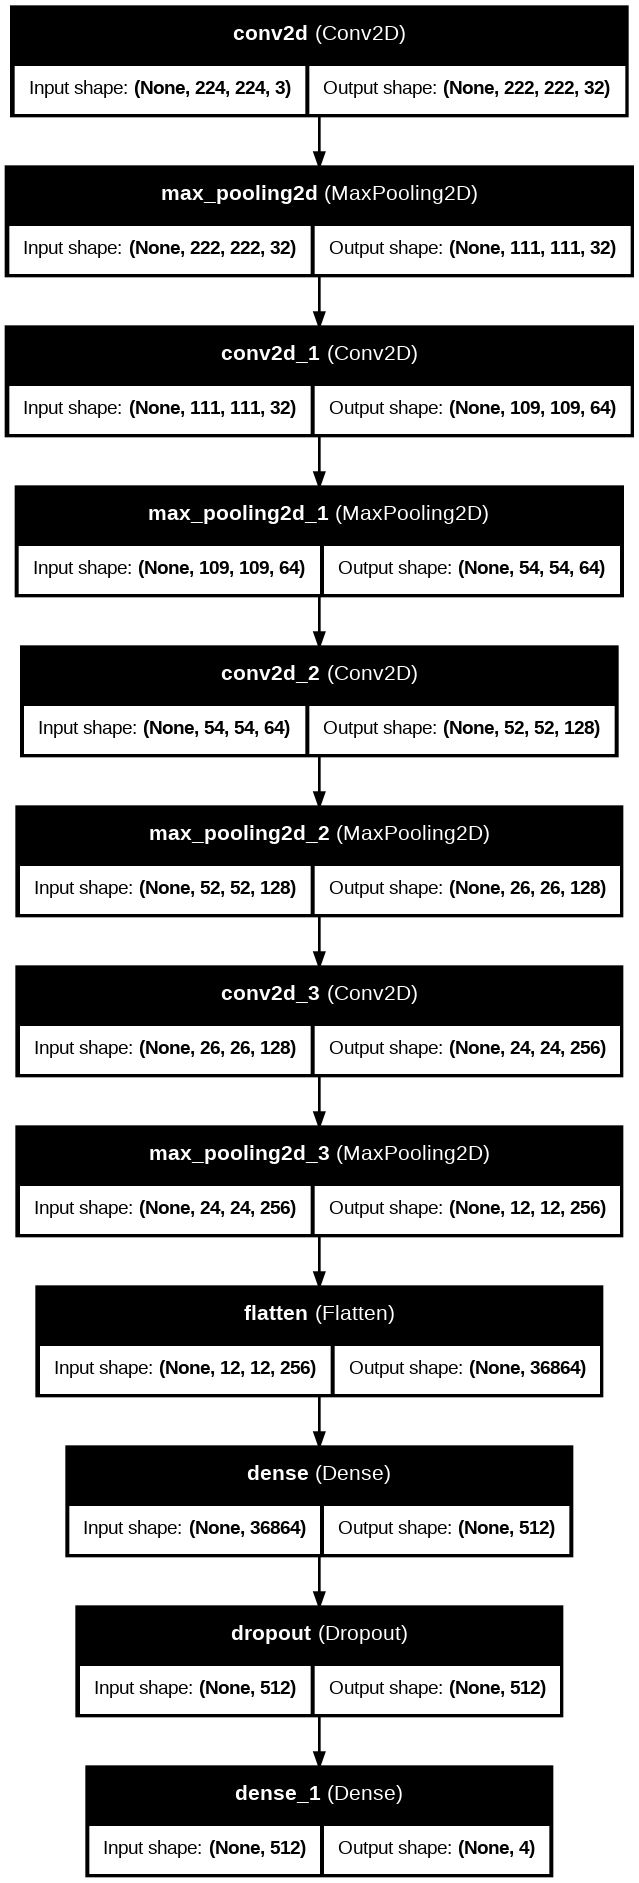

In [7]:
from tensorflow.keras.utils import plot_model

# Save the model diagram as an image file
plot_model(
    model,
    to_file='model_architecture.png',
    show_shapes=True,  # Show input/output shapes of each layer
    show_layer_names=True,  # Show layer names
    dpi=96  # Adjust DPI for better quality
)

# If you're using a notebook, you can display the image directly
from IPython.display import Image
Image('model_architecture.png')

In [8]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,  # Adjust epochs based on dataset size and performance
    # validation_data=test_generator,
    # validation_steps=test_generator.samples // test_generator.batch_size
)

Epoch 1/50


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


274/274 ━━━━━━━━━━━━━━━━━━━━ 168s 575ms/step - accuracy: 0.6421 - loss: 0.8759
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 30us/step - accuracy: 0.9688 - loss: 0.2761
Epoch 3/50


Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.


274/274 ━━━━━━━━━━━━━━━━━━━━ 130s 462ms/step - accuracy: 0.8335 - loss: 0.4177
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 21us/step - accuracy: 0.8750 - loss: 0.2763
Epoch 5/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 129s 460ms/step - accuracy: 0.8463 - loss: 0.3776
Epoch 6/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 19us/step - accuracy: 0.7812 - loss: 0.4472
Epoch 7/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 127s 453ms/step - accuracy: 0.8515 - loss: 0.3650
Epoch 8/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 20us/step - accuracy: 0.8438 - loss: 0.3083
Epoch 9/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 126s 449ms/step - accuracy: 0.8537 - loss: 0.3590
Epoch 10/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 19us/step - accuracy: 0.8438 - loss: 0.3692
Epoch 11/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 126s 448ms/step - accuracy: 0.8644 - loss: 0.3441
Epoch 12/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 19us/step - accuracy: 0.9062 - loss: 0.3736
Epoch 13/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 126s 448ms/step - accuracy: 0.8595 - loss: 0.3567
Epoch 14/50
274/274 ━━━━━━━━━━━━

In [9]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test accuracy: {test_acc*100:.2f}%")

68/68 ━━━━━━━━━━━━━━━━━━━━ 24s 329ms/step - accuracy: 0.9096 - loss: 0.2722
Test accuracy: 91.27%


In [32]:
# import matplotlib.pyplot as plt

# # Plot training loss
# plt.plot(history.history['loss'], label='Training Loss')
# plt.title('Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# # Plot training accuracy (if you tracked it during training)
# plt.plot(history.history['accuracy'], label='Training Accuracy')  # Use 'accuracy' or 'acc' depending on your model
# plt.title('Training Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# Prediction and Generating Reports

In [14]:
# Generate predictions for the validation or test set
predictions = model.predict(test_generator)  # Ensure you use the correct generator
predicted_classes = np.argmax(predictions, axis=1)

# Retrieve true labels from the generator
true_classes = test_generator.classes  # Ensure you use the same generator as in the prediction step

# Check the number of samples in true and predicted classes
print(f"Number of true labels: {len(true_classes)}")
print(f"Number of predicted labels: {len(predicted_classes)}")

# Ensure the lengths match
if len(true_classes) != len(predicted_classes):
    raise ValueError("Mismatch in number of true and predicted samples. Check the generator settings.")

# Get the class indices to use target names in the report
target_names = list(test_generator.class_indices.keys())

# Generate the classification report
from sklearn.metrics import classification_report
print(classification_report(true_classes, predicted_classes, target_names=target_names))

69/69 ━━━━━━━━━━━━━━━━━━━━ 14s 197ms/step
Number of true labels: 2200
Number of predicted labels: 2200
              precision    recall  f1-score   support

     class_0       0.92      0.92      0.92       758
    class_1+       0.82      0.86      0.84       538
    class_2+       0.91      0.77      0.83       226
    class_3+       0.98      1.00      0.99       678

    accuracy                           0.91      2200
   macro avg       0.91      0.89      0.90      2200
weighted avg       0.91      0.91      0.91      2200



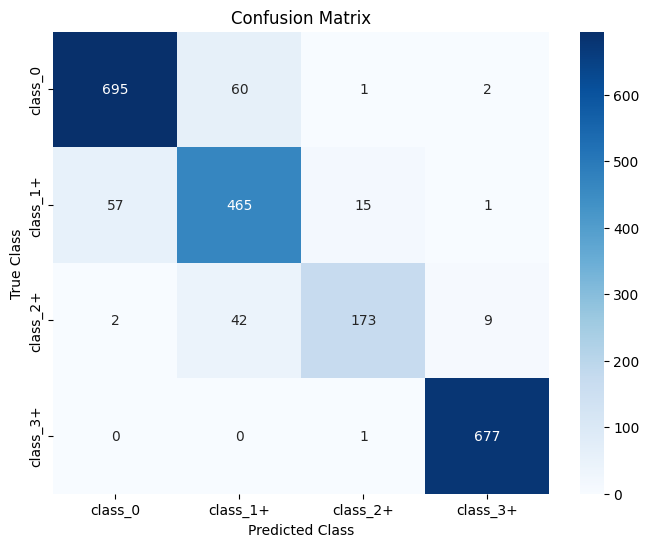

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

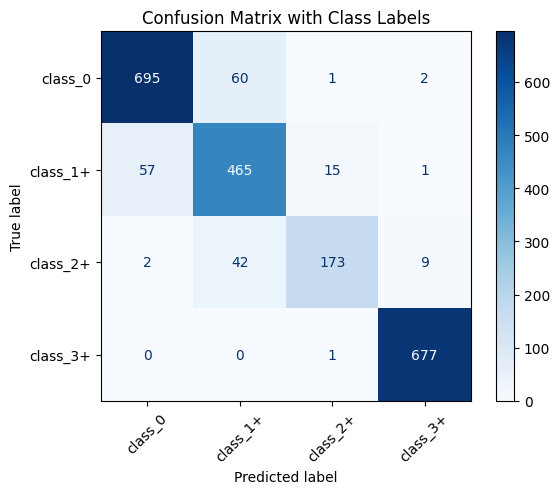

In [17]:
# Optional: Use sklearn's built-in confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix with Class Labels")
plt.show()

In [19]:
# Print available variables
print(globals().keys())  

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', '_', '__', '___', '_i', '_ii', '_iii', '_i1', 'version_info', '_i2', 'f', '_i3', 'np', 'pd', 'plt', 'sns', 'train_test_split', 'classification_report', 'confusion_matrix', 'tf', 'keras', 'layers', 'models', 'ImageDataGenerator', 'cv2', 'os', 'shap', 'image', 'K', '_i4', '_i5', 'train_dir', 'test_dir', 'IMG_HEIGHT', 'IMG_WIDTH', 'train_datagen', 'test_datagen', 'train_generator', 'test_generator', '_i6', 'build_custom_cnn', 'model', '_i7', 'plot_model', 'Image', '_7', '_i8', 'history', '_i9', 'test_loss', 'test_acc', '_i10', '_i11', 'predictions', 'predicted_classes', 'true_classes', 'target_names', '_i12', '_i13', 'roc_curve', 'auc', 'to_categorical', '_i14', '_i15', 'ConfusionMatrixDisplay', 'class_labels', 'conf_matrix', '_i16', '_i17', 'disp', '_i18', '_i19'])


In [30]:
y_test = test_generator.classes  # Extract ground truth labels

69/69 ━━━━━━━━━━━━━━━━━━━━ 13s 184ms/step


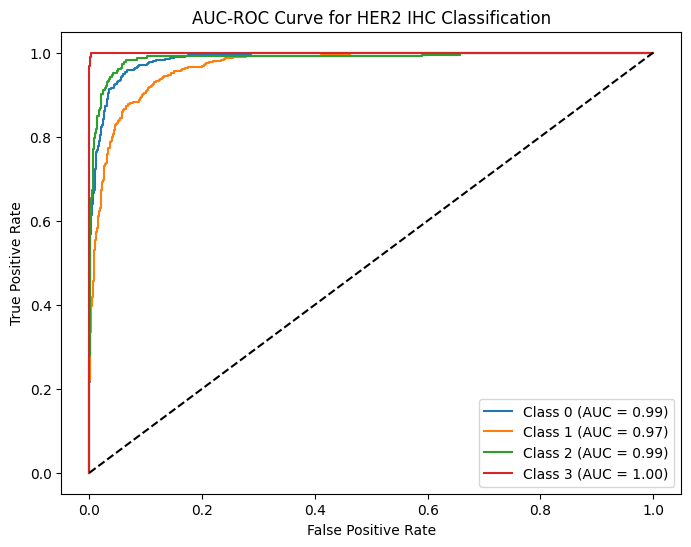

In [31]:
# ✅ Convert y_test to one-hot encoding
y_test_onehot = to_categorical(y_test, num_classes=4)

# ✅ Get model predictions
y_probs = model.predict(test_generator)  # Use test_generator instead of X_test

# ✅ Compute ROC Curve & AUC for each class
plt.figure(figsize=(8, 6))
for i in range(4):  # Assuming 4 classes
    fpr, tpr, _ = roc_curve(y_test_onehot[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

# ✅ Plot ROC Curve
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve for HER2 IHC Classification")
plt.legend(loc="lower right")
plt.show()

In [23]:
# Specify the path where you want to save the model
model_save_path = "/kaggle/working/train_updated.h5"  # Use .h5 for HDF5 format or .tf for TensorFlow SavedModel format

# Save the trained model
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /kaggle/working/train_updated.h5


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,874,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,796,046 (220.47 MB)

 Trainable params: 19,265,348 (73.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,530,698 (146.98 MB)

In [16]:
for layer in model.layers:
    print(layer.name)

conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
conv2d_3
max_pooling2d_3
flatten
dense
dropout
dense_1


In [17]:
print(model.input_shape)  # Expected input shape for the model

(None, 224, 224, 3)


In [25]:
_ = model.predict(test_generator)  # Ensure the model is run at least once

69/69 ━━━━━━━━━━━━━━━━━━━━ 13s 193ms/step
